In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf

In [12]:
path = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/Light_conversion/"

fluo_liquide = pd.read_csv(path + "20240229_Fluo_liquide_spectrum" + ".csv", delimiter=";", decimal=".")
PSI_instrument = pd.read_csv(path + "20241029_PSI_instrument" + ".csv", delimiter=";", decimal=".")

def normalize_spectra(spectra):
    spectra_baseline = np.mean(spectra["intensity"][tools.closest_index(spectra["wavelength"], 300):tools.closest_index(spectra["wavelength"], 400)])
    spectra["intensity"] = spectra["intensity"] - spectra_baseline
    spectra["intensity"] = spectra["intensity"] / np.trapz(spectra["intensity"], spectra["wavelength"])
    return spectra

fluo_liquide = normalize_spectra(fluo_liquide)
PSI_instrument = normalize_spectra(PSI_instrument)

In [13]:
path_phaeo = path + "20241029_phaeo/"

fig_folder = path_phaeo + "figs/"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
    
phaeo = pd.read_csv(path_phaeo + "20241029_phaeo" + ".csv", delimiter=";", decimal=".")




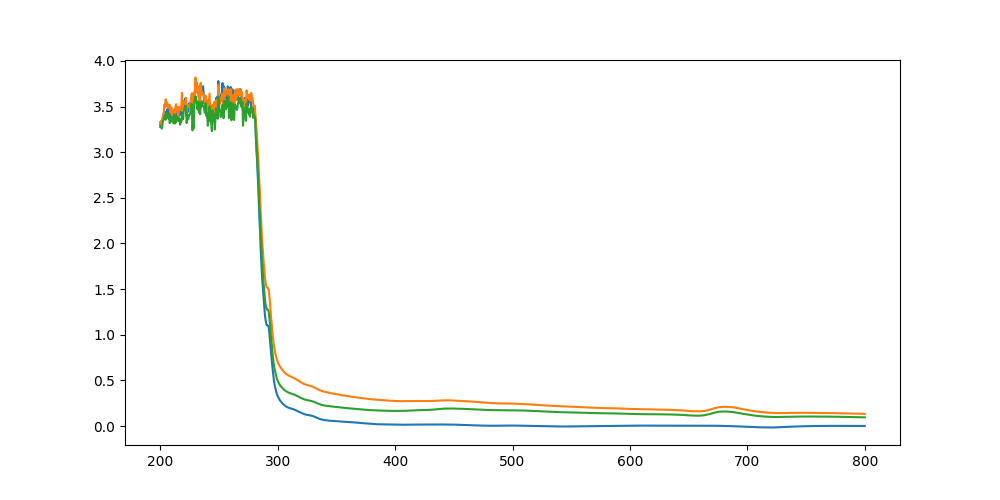

In [14]:
fis, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(phaeo["wavelength"], phaeo["blank"], label="blank")
ax.plot(phaeo["wavelength"], phaeo["Pt2"], label="Pt2")
ax.plot(phaeo["wavelength"], phaeo["Pt1"], label="Pt1")



Text(0, 0.5, 'Absortion')

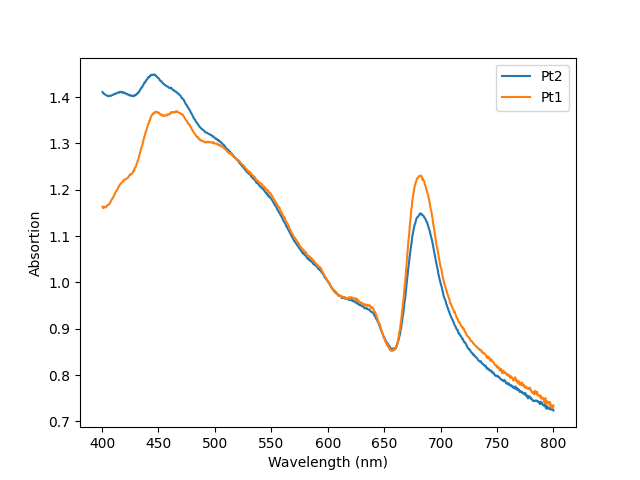

In [15]:
i_start = tools.closest_index(phaeo["wavelength"], 800)
i_end = tools.closest_index(phaeo["wavelength"], 400)

wavelength_uv_vis = phaeo["wavelength"][i_start:i_end]
Pt2 = phaeo["Pt2"][i_start:i_end] - phaeo["blank"][i_start:i_end]
Pt1 = phaeo["Pt1"][i_start:i_end] - phaeo["blank"][i_start:i_end]

i_start_norm = tools.closest_index(wavelength_uv_vis, 640)
i_end_norm = tools.closest_index(wavelength_uv_vis, 600)

Pt2 = Pt2 / max(Pt2[i_start_norm:i_end_norm])
Pt1 = Pt1 / max(Pt1[i_start_norm:i_end_norm])

fig, ax = plt.subplots()
ax.plot(wavelength_uv_vis, Pt2, label="Pt2")
ax.plot(wavelength_uv_vis, Pt1, label="Pt1")
ax.legend()

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absortion")


Text(0.5, 1.0, 'Normalized emission spectra')

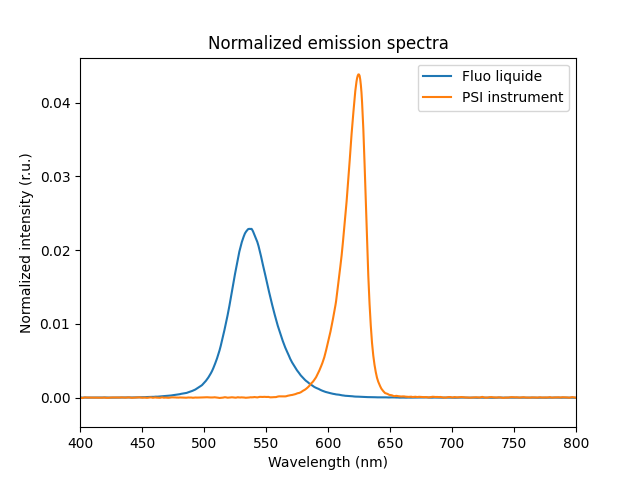

In [16]:
fig, ax = plt.subplots()
ax.plot(fluo_liquide["wavelength"], fluo_liquide["intensity"], label="Fluo liquide")
ax.plot(PSI_instrument["wavelength"], PSI_instrument["intensity"], label="PSI instrument")
ax.legend()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Normalized intensity (r.u.)")
ax.set_xlim(400, 800)
ax.set_title("Normalized emission spectra")



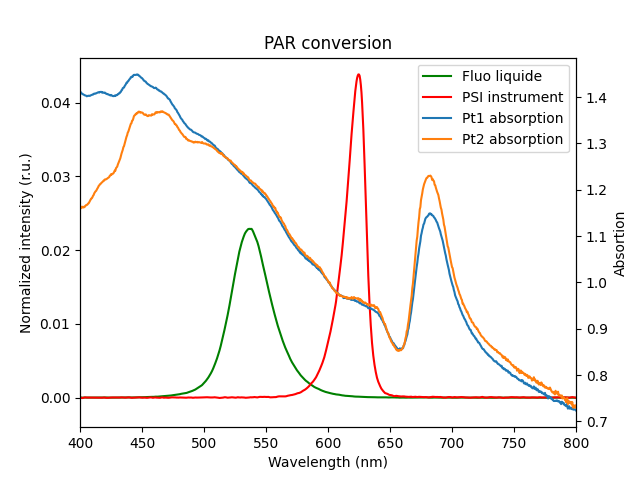

In [17]:
fig, ax = plt.subplots()
ax.plot(fluo_liquide["wavelength"], fluo_liquide["intensity"], label="Fluo liquide", color="green")
ax.plot(PSI_instrument["wavelength"], PSI_instrument["intensity"], label="PSI instrument", color = "red")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Normalized intensity (r.u.)")
ax.set_xlim(400, 800)
ax.set_title("PAR conversion")

ax2 = ax.twinx()

ax2.plot(wavelength_uv_vis, Pt2, label="Pt2")
ax.plot([], [], label="Pt1 absorption", color = "C0")
ax2.plot(wavelength_uv_vis, Pt1, label="Pt1")
ax.plot([], [], label="Pt2 absorption", color = "C1")
ax2.set_ylabel("Absortion")
ax.legend()

fig.savefig(fig_folder + "PAR_conversion.png", dpi=300)



Text(0.5, 0, 'Wavelength (nm)')

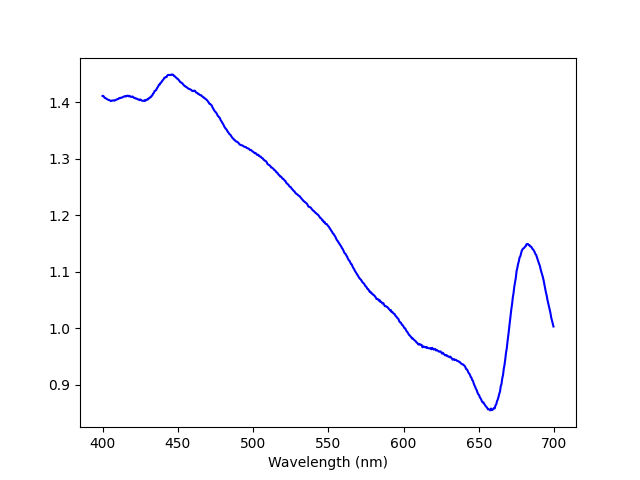

In [22]:
common_x = np.arange(400, 700, 0.5)

interpolate_fluo_liquide = np.interp(common_x, fluo_liquide["wavelength"], fluo_liquide["intensity"])
interpolate_PSI_instrument = np.interp(common_x, PSI_instrument["wavelength"], PSI_instrument["intensity"])
interpolate_Pt2 = np.interp(common_x, wavelength_uv_vis[::-1], Pt2[::-1])

fig, ax = plt.subplots()
# ax.plot(common_x, interpolate_fluo_liquide, label="Fluo liquide", color="green")
# ax.plot(common_x, interpolate_PSI_instrument, label="PSI instrument", color = "red")
ax.plot(common_x, interpolate_Pt2, label="Pt2", color = "blue")
ax.set_xlabel("Wavelength (nm)")



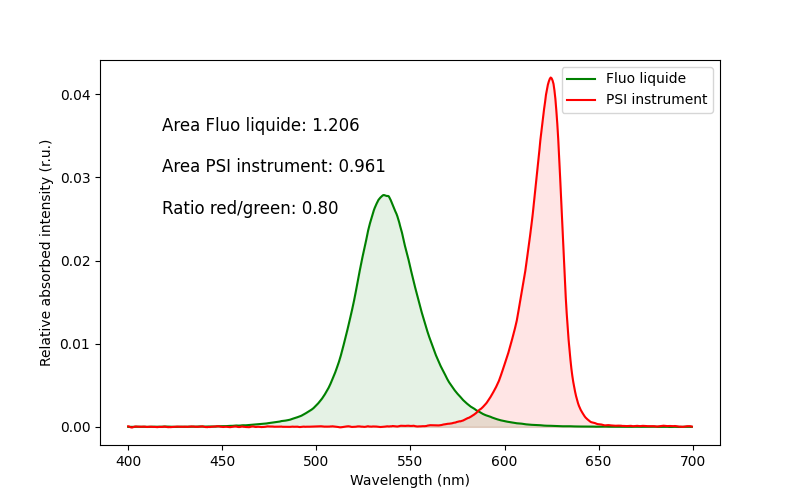

In [23]:
absorbed_fluo_liquide = interpolate_fluo_liquide * interpolate_Pt2
absorbed_PSI_instrument = interpolate_PSI_instrument * interpolate_Pt2

area_absorbed_fluo_liquide = np.trapz(absorbed_fluo_liquide, common_x)
area_absorbed_PSI_instrument = np.trapz(absorbed_PSI_instrument, common_x)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(common_x, absorbed_fluo_liquide, label="Fluo liquide", color = "green")
ax.plot(common_x, absorbed_PSI_instrument, label="PSI instrument", color = "red")
ax.fill_between(common_x, 0, absorbed_fluo_liquide, color="green", alpha=0.1)
ax.fill_between(common_x, 0, absorbed_PSI_instrument, color="red", alpha=0.1)
ax.legend()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Relative absorbed intensity (r.u.)")

ax.text(0.1, 0.6, f"Area Fluo liquide: {area_absorbed_fluo_liquide:.3f}\n\nArea PSI instrument: {area_absorbed_PSI_instrument:.3f}\n\nRatio red/green: {area_absorbed_PSI_instrument/area_absorbed_fluo_liquide:.2f}", transform=ax.transAxes, fontsize=12)

fig.savefig(fig_folder + "Areas.png", dpi=300)

In [26]:
def normalize(data):
    min_val = min(data)
    max_val = max(data)
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
    return normalized_data

In [29]:
Pt2_norm_zero = phaeo["Pt2"][i_start:i_end] - phaeo["blank"][i_start:i_end]
Pt2_norm_zero = normalize(Pt2_norm_zero)

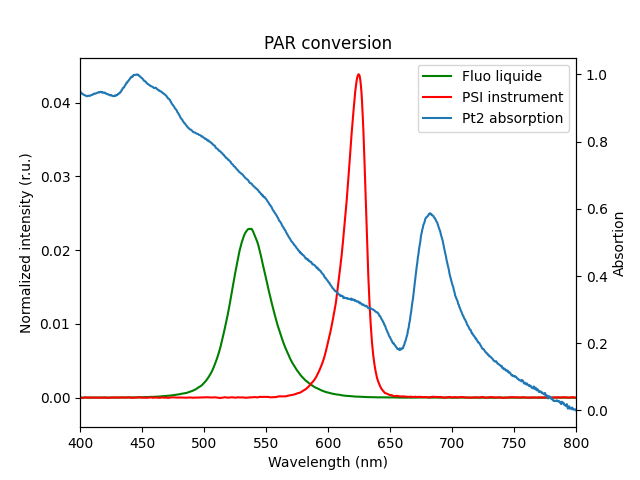

In [30]:
fig, ax = plt.subplots()
ax.plot(fluo_liquide["wavelength"], fluo_liquide["intensity"], label="Fluo liquide", color="green")
ax.plot(PSI_instrument["wavelength"], PSI_instrument["intensity"], label="PSI instrument", color = "red")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Normalized intensity (r.u.)")
ax.set_xlim(400, 800)
ax.set_title("PAR conversion")

ax2 = ax.twinx()

ax2.plot(wavelength_uv_vis, Pt2_norm_zero, label="Pt2")
ax.plot([], [], label="Pt2 absorption", color = "C0")

ax2.set_ylabel("Absortion")
ax.legend()

fig.savefig(fig_folder + "PAR_conversion.png", dpi=300)


Text(0.5, 0, 'Wavelength (nm)')

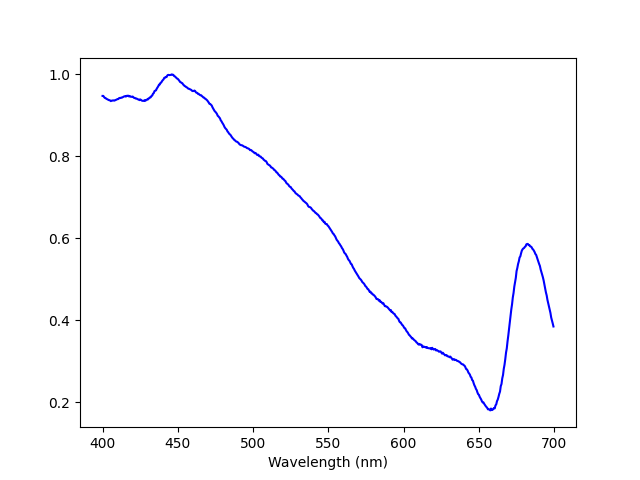

In [ ]:
common_x = np.arange(400, 700, 0.5)

interpolate_fluo_liquide = np.interp(common_x, fluo_liquide["wavelength"], fluo_liquide["intensity"])
interpolate_PSI_instrument = np.interp(common_x, PSI_instrument["wavelength"], PSI_instrument["intensity"])
interpolate_Pt2 = np.interp(common_x, wavelength_uv_vis[::-1], Pt2_norm_zero[::-1])

fig, ax = plt.subplots()
# ax.plot(common_x, interpolate_fluo_liquide, label="Fluo liquide", color="green")
# ax.plot(common_x, interpolate_PSI_instrument, label="PSI instrument", color = "red")
ax.plot(common_x, interpolate_Pt2, label="Pt2", color = "blue")
ax.set_xlabel("Wavelength (nm)")

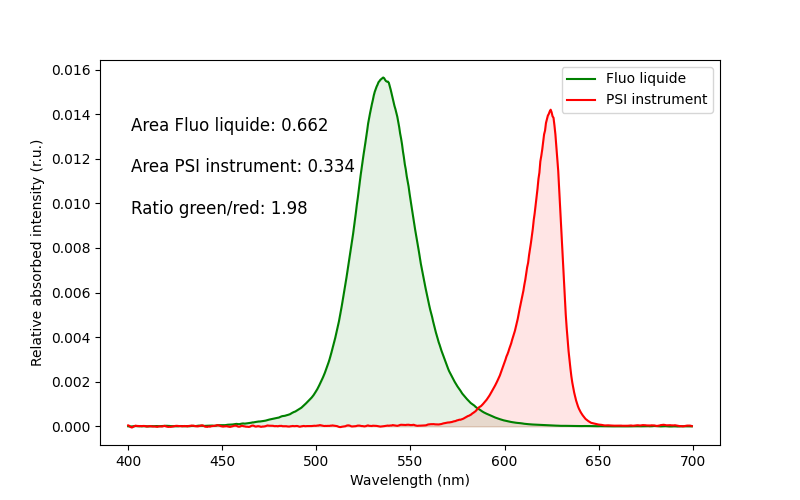

In [34]:
absorbed_fluo_liquide = interpolate_fluo_liquide * interpolate_Pt2
absorbed_PSI_instrument = interpolate_PSI_instrument * interpolate_Pt2

area_absorbed_fluo_liquide = np.trapz(absorbed_fluo_liquide, common_x)
area_absorbed_PSI_instrument = np.trapz(absorbed_PSI_instrument, common_x)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(common_x, absorbed_fluo_liquide, label="Fluo liquide", color = "green")
ax.plot(common_x, absorbed_PSI_instrument, label="PSI instrument", color = "red")
ax.fill_between(common_x, 0, absorbed_fluo_liquide, color="green", alpha=0.1)
ax.fill_between(common_x, 0, absorbed_PSI_instrument, color="red", alpha=0.1)
ax.legend()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Relative absorbed intensity (r.u.)")

ax.text(0.05, 0.6, f"Area Fluo liquide: {area_absorbed_fluo_liquide:.3f}\n\nArea PSI instrument: {area_absorbed_PSI_instrument:.3f}\n\nRatio green/red: {area_absorbed_fluo_liquide/area_absorbed_PSI_instrument:.2f}", transform=ax.transAxes, fontsize=12)

fig.savefig(fig_folder + "Areas.png", dpi=300)